In [1]:
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split

/Users/nuradilserik/miniconda3/envs/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
df = pd.read_csv("../data/processed/combined_balanced.csv")
df = df[['clean_text', 'has_toxicity']].dropna()
df = df.rename(columns={'clean_text': 'text', 'has_toxicity': 'label'})
df['label'] = df['label'].astype(int)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [5]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

Map: 100%|██████████| 8154/8154 [00:00<00:00, 11099.83 examples/s]


In [ ]:
from transformers import BertForSequenceClassification, TrainingArguments, Trainer

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
training_args = TrainingArguments(
    output_dir="./results",
    logging_dir="./logs",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    save_steps=500,           
    eval_steps=500,          
    logging_steps=100       
    # load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
trainer.train()

Step,Training Loss
100,0.141700
200,0.097100
300,0.080100
400,0.100000
500,0.097200
600,0.245800
700,0.222600
800,0.212400
900,0.209800
1000,0.230000


TrainOutput(global_step=10195, training_loss=0.07945865470187052, metrics={'train_runtime': 16171.7444, 'train_samples_per_second': 10.083, 'train_steps_per_second': 0.63, 'total_flos': 4.29028886870016e+16, 'train_loss': 0.07945865470187052, 'epoch': 5.0})

In [16]:
metrics = trainer.evaluate()
print(metrics)

{'eval_loss': 0.3971875011920929, 'eval_runtime': 244.5928, 'eval_samples_per_second': 33.337, 'eval_steps_per_second': 2.085, 'epoch': 5.0}


In [20]:
trainer.save_model("../models/final_model")
tokenizer.save_pretrained("../models/final_model")

('../models/final_model/tokenizer_config.json',
 '../models/final_model/special_tokens_map.json',
 '../models/final_model/vocab.txt',
 '../models/final_model/added_tokens.json',
 '../models/final_model/tokenizer.json')

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

predictions = trainer.predict(test_dataset)

y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Classification report
report = classification_report(y_true, y_pred, target_names=["Non-Toxic", "Toxic"])
print(report)

              precision    recall  f1-score   support

   Non-Toxic       0.94      0.93      0.94      4132
       Toxic       0.93      0.94      0.94      4022

    accuracy                           0.94      8154
   macro avg       0.94      0.94      0.94      8154
weighted avg       0.94      0.94      0.94      8154



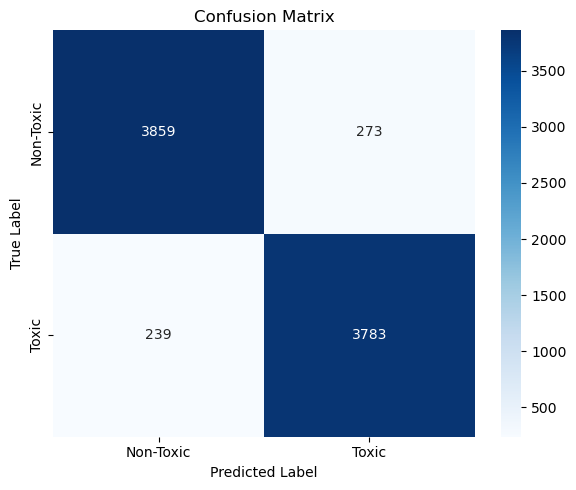

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)
labels = ["Non-Toxic", "Toxic"]

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

